# Olympic Effect with EuroSAT

## 2020년 09월 01일 안상호

In [57]:
from pathlib import Path

# Sangho Workspace|
root_dir = Path("/home/jovyan/")
base_dir = root_dir  / 'Land-Cls'

data_path = base_dir / "data" 

In [58]:
import sys
import os

# Google Colab Version
# sys.path.append(str(base_dir))


# Local Version
PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser("__file__"))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

In [59]:
from fastai.vision import *
from fastai.vision import image as im
from utils import preprocess, model #earth

# 1. Load  Classifier

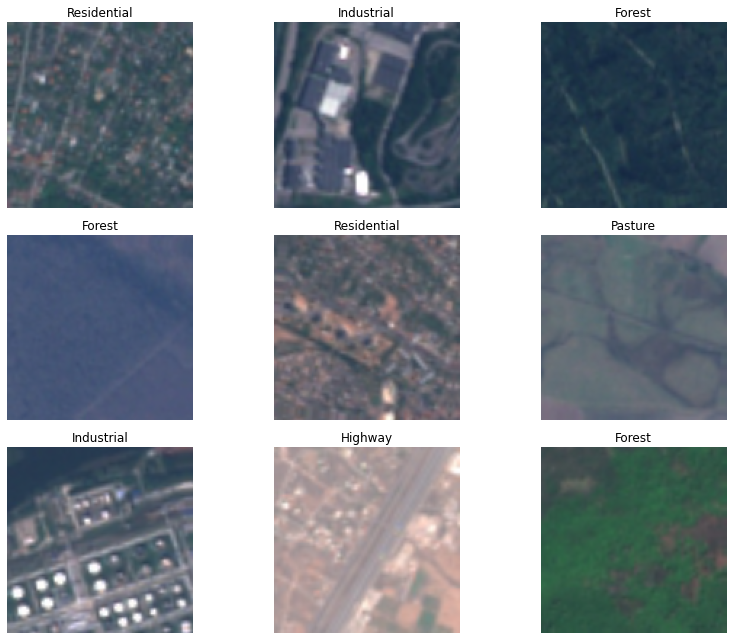

In [56]:


parameters = {
    "path" : data_path / "eurosat",
    "bs" : 64, 
    "size" : 128, 
    "valid_pct" : 0.2,

    "metrics" : [accuracy],
    "pretrained" : False, 
    "load_dir": base_dir / "learn" / "euro-res50-2"
}

vis = model.FastVision(models.resnet50, parameters, task="classification")

# 2. Predict Land Cover

## 2.1. 이미지 크롭

In [60]:
import PIL
from torchvision import transforms

def crop_image_square(image, current_x, current_y, tile=(256, 256)):
    """
    PIL 이미지를 tile 만큼의 정방 형태의 크기로 crop 합니다.
    """
    return image.crop((current_x, current_y, current_x + tile[0], current_y + tile[1]))



def convert_fastai_image(image:PIL.JpegImagePlugin.JpegImageFile):
    """
    PIL 형태의 이미지를 fastai를 위한 Image로 바꿔준다. 
    Ref:: https://forums.fast.ai/t/how-to-convert-a-pil-image-to-a-fastai-image-object/68407/3
    """
    return im.Image(transforms.ToTensor()(image))



HerbaceousVegetation


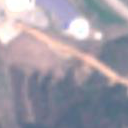

In [65]:
image = PIL.Image.open(data_path/ "olympic" / "V2"/ "y2016_PC_01_ Alpensia.jpg")


tile = crop_image_square(image, 1500 , 1700, tile=(128, 128))
print(str(vis.learn.predict(convert_fastai_image(tile))[0]))
tile

In [20]:
def caculate_land_use(image_path, model, labels, tile=(64, 64)):
    image = PIL.Image.open(image_path)
    width, height = image.size
    tile_width, tile_height = tile
    
    result_dict = dict((label,0) for label in labels)
    currentx, currenty = (0, 0)
    
    
    while currenty < height:
        while currentx < width:
            #print(currentx,",",currenty)
            tile = crop_image_square(image, currentx, currenty, (tile_width, tile_height)) 

            result_dict[str(model.predict(convert_fastai_image(tile))[0])] +=1
            currentx += tile_width
        currenty += tile_height
        currentx = 0
    return result_dict
    
labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
          'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

result = caculate_land_use(data_path/ "olympic" / "V3" / "y2018_PC_02_Station.jpg", vis.learn, labels, (256, 256))


In [21]:
def get_dict_percent(count_dict):
    values = count_dict.values()
    total = sum(values)
    return [value / total for value in values]

for k, v in zip(result.keys(), get_dict_percent(result)):
    print(f"{k}: {v}")

AnnualCrop: 0.006493506493506494
Forest: 0.025974025974025976
HerbaceousVegetation: 0.6363636363636364
Highway: 0.0
Industrial: 0.0
Pasture: 0.0
PermanentCrop: 0.006493506493506494
Residential: 0.17532467532467533
River: 0.0
SeaLake: 0.14935064935064934


## 2.2. 장소별 적용

In [22]:
df_location = pd.DataFrame([["알펜시아", 37.658251, 128.669856, "PC_01_ Alpensia.jpg"],
                            ["진부역", 37.642935, 128.574451, "PC_02_Station.jpg"],
                            ["올림픽 게이트웨이", 37.668117, 128.705676, "PC_03_Gate.jpg"],
                            ["자연휴양", 37.705692, 128.720683, "PC_04_Nature.jpg"],
                            ["평창역", 37.562846,  128.429930, "PC_05_Station.jpg"]], columns=["name", "lat", "lon", "image_name"])

df_location.head()

,name,lat,lon,image_name
0,알펜시아,37.658251,128.669856,PC_01_ Alpensia.jpg
1,진부역,37.642935,128.574451,PC_02_Station.jpg
2,올림픽 게이트웨이,37.668117,128.705676,PC_03_Gate.jpg
3,자연휴양,37.705692,128.720683,PC_04_Nature.jpg
4,평창역,37.562846,128.429930,PC_05_Station.jpg


In [73]:
labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
          'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
cols = ["name", "year"] + labels

tile = (128, 128) #(256, 256)

In [74]:
years = ["2016", "2017", "2018", "2019", "2020"]
result_list = []
for idx, row in df_location.iterrows():
    for year in years:
        
        
        meta_list = [row["name"], year]
        land_use = caculate_land_use(data_path/ "olympic" / "V4" /f"y{year}_{row.image_name}",
                                     vis.learn, labels, tile)
        result_list.append(meta_list + get_dict_percent(land_use))
    print(meta_list[0], " finished")
        

        
df_result = pd.DataFrame(result_list, columns=cols)

알펜시아  finished
진부역  finished
올림픽 게이트웨이  finished
자연휴양  finished
평창역  finished


In [75]:
df_result

,name,year,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
0,알펜시아,2016,0.000000,0.007055,0.784832,0.010582,0.001764,0.0,0.038801,0.102293,0.003527,0.051146
1,알펜시아,2017,0.000000,0.005291,0.844797,0.008818,0.001764,0.0,0.022928,0.072310,0.000000,0.044092
2,알펜시아,2018,0.000000,0.000000,0.841270,0.010582,0.010582,0.0,0.028219,0.061728,0.001764,0.045855
3,알펜시아,2019,0.000000,0.000000,0.850088,0.012346,0.003527,0.0,0.010582,0.075838,0.000000,0.047619
4,알펜시아,2020,0.001764,0.000000,0.772487,0.008818,0.003527,0.0,0.047619,0.104056,0.000000,0.061728
5,진부역,2016,0.000000,0.014109,0.779541,0.010582,0.000000,0.0,0.063492,0.093474,0.001764,0.037037
6,진부역,2017,0.000000,0.008818,0.834215,0.012346,0.003527,0.0,0.040564,0.061728,0.000000,0.038801
7,진부역,2018,0.000000,0.007055,0.855379,0.012346,0.001764,0.0,0.029982,0.056437,0.000000,0.037037
8,진부역,2019,0.000000,0.001764,0.823633,0.012346,0.003527,0.0,0.029982,0.091711,0.000000,0.037037
9,진부역,2020,0.001764,0.001764,0.827160,0.008818,0.000000,0.0,0.051146,0.068783,0.001764,0.038801


In [76]:
import plotly.express as px

# df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df_result, x="year", y="HerbaceousVegetation", color='name')
fig.show()

In [77]:
import plotly.express as px

# df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df_result, x="year", y="Residential", color='name')
fig.show()